# Assignment 2

- Train a linear regression model that maps features to expert scores based on the dataset
- Try different variants using, e.g., feature selection, combined features, removal of outlier and leverage data points, apply symmetry constraints, weighted linear regression
- Assess the accuracy of the models and select a champion variant

## Imports

In [1]:
import sys

sys.path.append("../../scripts")

import dagshub
import mlflow
import ml_utils as MLUtils

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate

## Setup

In [2]:
# Setup dagshub and MLFlow
dagshub.init(repo_owner="SamuelFredricBerg", repo_name="4dt907", mlflow=True)
utils = MLUtils.MLUtils("Project_Model_A2_V2")

# Configs
config = {
    "data_split_seed": 42,
    "test_size": 0.2,
    "n_folds": 10,
    "shuffle": True,
    "variant": "Remove outliers/Removing dupes",
    "threshold_multiplier": 5,
    "n_alphas": 100, 
    "max_iter": 50000,
    "poly_degree": 2,
    "include_bias": False
}

data_path = "../../data/AimoScore_WeakLink_big_scores_A2.csv"

df = pd.read_csv(data_path, index_col=0)

kf = KFold(
    n_splits=config["n_folds"],
    shuffle=config["shuffle"],
    random_state=config["data_split_seed"],
)

Accessing as Soppa22

Initialized MLflow to track repo "SamuelFredricBerg/4dt907"

Repository SamuelFredricBerg/4dt907 initialized!

# Preprocessing

In [3]:
def preprocessing(df):
    df_cleaned = df.drop("EstimatedScore", axis=1)
    df_cleaned = df_cleaned.drop_duplicates()
    return df_cleaned

In [4]:
def remove_outliers_cooks(X, y):
    X_const = sm.add_constant(X)
    influence = sm.OLS(y, X_const).fit().get_influence()
    cooks_d = influence.cooks_distance[0]
    threshold = config["threshold_multiplier"] / len(X)
    mask = cooks_d < threshold
    return mask

# Training

In [5]:
def fitReg(X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=config["test_size"], random_state=config["data_split_seed"]
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return model, y_pred, y_test

In [6]:
from sklearn.preprocessing import PolynomialFeatures


def fit_lasso(X, y, kf_object):
    model = make_pipeline(
        StandardScaler(), 
        PolynomialFeatures(degree=config["poly_degree"], include_bias=config["include_bias"]), # Standard degree 2 (includes squares)
        LassoCV(cv=kf_object, n_alphas=config["n_alphas"], max_iter=config["max_iter"], random_state=config["data_split_seed"]) # Increase cv and alphas for precision
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=config["test_size"], random_state=config["data_split_seed"]
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Optional: Print how many features Lasso kept
    lasso_layer = model.named_steps['lassocv']
    kept_features = sum(lasso_layer.coef_ != 0)
    print(f"Lasso kept {kept_features} out of {X.shape[1]} features.")
    
    return model, y_pred, y_test

In [7]:
def crossval_boxplots_regression(r2_raw, mae_raw, mse_raw):
    # 1. Create a dictionary of the regression metrics
    # Note: Using absolute values for MAE/MSE if they were negative from scoring
    raw_data = {
        'R2 Score': r2_raw,
    }
    
    # 2. Convert to 'Long Format' for Seaborn
    df_plot = pd.DataFrame(raw_data).melt(var_name='Metric', value_name='Score')
    
    # 3. Plotting
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Create the boxplot and swarmplot
    # We use 'hue' or separate subplots if the scales are too different, 
    # but for stability visualization, a standard categorical x-axis works.
    ax = sns.boxplot(x='Metric', y='Score', data=df_plot, palette="Set2", width=0.5)
    sns.swarmplot(x='Metric', y='Score', data=df_plot, color=".25", size=5)

    plt.title(f'Regression Model Stability: {config["variant"]}')
    plt.ylabel('Metric Value')
    
    # Optional: If MAE/MSE are on a totally different scale than R2, 
    # you might want to plot R2 separately.
    plt.savefig("regression_boxplot.png")
    plt.show()

## Main Code

Number of columns: 40
Columns names: ['No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation', 'No_10_Angle_Deviation', 'No_11_Angle_Deviation', 'No_12_Angle_Deviation', 'No_13_Angle_Deviation', 'No_1_NASM_Deviation', 'No_2_NASM_Deviation', 'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation', 'No_6_NASM_Deviation', 'No_7_NASM_Deviation', 'No_8_NASM_Deviation', 'No_9_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation', 'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_14_NASM_Deviation', 'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation', 'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_20_NASM_Deviation', 'No_21_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_24_NASM_Deviation', 'No_25_NASM_Deviation', 'No_1_Time_Deviation', 'No_2_Time_Deviation']
The Run I

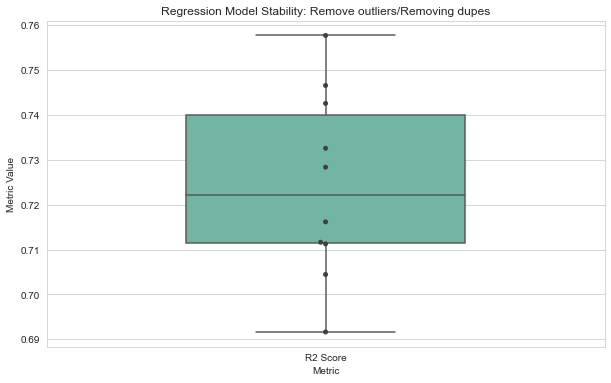

Total columns in merged data: 41
Columns used as predictors: 38
Excluded columns: {'No_1_Time_Deviation', 'AimoScore', 'No_2_Time_Deviation'}
{'R2_Mean': 0.7243108809142321, 'R2_Std': 0.01972836360544096, 'MAE_Mean': 0.09009856106371902, 'MAE_Std': 0.005650997405330114, 'MSE_Mean': 0.01435508748835897, 'MSE_Std': 0.0018566799096314346}


Comparing PDFs


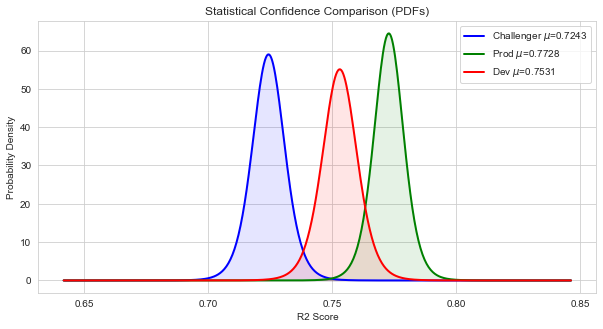

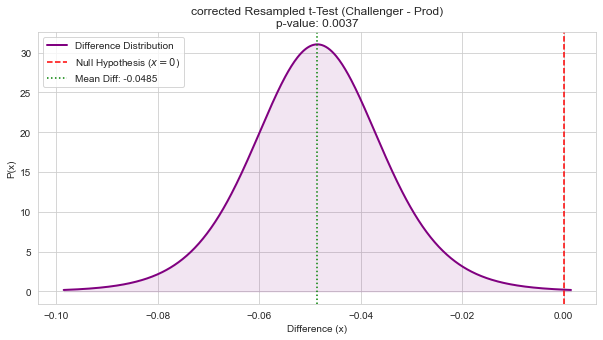

Keep @prod: Improvement not significant (p=0.0037)
Did not beat current @dev, model not uploaded to Dagshub
🏃 View run A2-Training-Lasso at: https://dagshub.com/SamuelFredricBerg/4dt907.mlflow/#/experiments/0/runs/e93f6362fd5e47cf87f81244e806d0bd
🧪 View experiment at: https://dagshub.com/SamuelFredricBerg/4dt907.mlflow/#/experiments/0


In [8]:
df_cleaned = preprocessing(df)

df_names = df_cleaned.columns.tolist()
df_cleaned = df_cleaned.reset_index()
print(f"Number of columns: {len(df_names)}")
print(f"Columns names: {df_names}")

df_cleaned.describe()


with mlflow.start_run(run_name="A2-Training-Lasso") as run:
    mlflow.log_params(config)
    current_run_id = run.info.run_id
    print(f"The Run ID is: {current_run_id}")

    y = df_cleaned["AimoScore"]
    X = df_cleaned.drop(
        ["AimoScore", "No_1_Time_Deviation", "No_2_Time_Deviation", "EstimatedScore"],
        axis=1,
        errors="ignore",
    )

    mask = remove_outliers_cooks(X, y)
    X_clean = X[mask]
    y_clean = y[mask]

    model, y_pred, y_test = fit_lasso(X_clean, y_clean, kf)



    cv_results = cross_validate(model, X_clean, y_clean, cv=kf, 
                                scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'])
    
    r2_scores = cv_results['test_r2']
    mae_scores = -cv_results['test_neg_mean_absolute_error']
    mse_scores = -cv_results['test_neg_mean_squared_error']

    current_scores_df = pd.DataFrame({
        'r2': r2_scores,
        'mae': mae_scores,
        'mse': mse_scores
    })
    current_scores_df.to_csv("cv_fold_scores.csv", index=False)
    mlflow.log_artifact("cv_fold_scores.csv")

    crossval_boxplots_regression(r2_scores, mae_scores, mse_scores)

    print(f"Total columns in merged data: {len(df_cleaned.columns)}")
    print(f"Columns used as predictors: {len(X.columns)}")
    print(f"Excluded columns: {set(df_cleaned.columns) - set(X.columns)}")

    results = {
        "R2_Mean": r2_scores.mean(),
        "R2_Std": r2_scores.std(),
        "MAE_Mean": mae_scores.mean(),
        "MAE_Std": mae_scores.std(),
        "MSE_Mean": mse_scores.mean(),
        "MSE_Std": mse_scores.std(),
    }
    print(results)
    mlflow.log_metrics(results)

    mlflow.log_artifact("regression_boxplot.png")

    is_better, p_val = utils.is_challenger_statistically_better(current_scores_df)

    if is_better:
        print(f"New model is statistically superior to @prod (p={p_val:.4f})")
    else:
        print(f"Keep @prod: Improvement not significant (p={p_val:.4f})")

    if utils.auto_check_challenger(run.info.run_id, metric_name="R2_Mean"):
        mlflow.sklearn.log_model(model, "model", registered_model_name="Project_Model_A2_V2")
        latest_v = utils.client.get_latest_versions("Project_Model_A2_V2")[0].version
        utils.client.set_registered_model_alias("Project_Model_A2_V2", "dev", latest_v)
        print("New model beat current @dev uploading to DagsHub")
    else:
        print("Did not beat current @dev, model not uploaded to Dagshub")